In [1]:
import matplotlib.pyplot as plt
from SpatialAxis.spatial_axis import spatial_axis_to_labelmap
from SpatialAxis import spatial_axis
from SpatialAxis.utility import random_shapely_circles, create_broad_annotation_polygons
import geopandas
from rasterio.features import rasterize
import numpy as np
import numpy
import warnings
import scipy
import typing

,geometry
0,"POLYGON ((114.542 243.383, 114.452 241.554, 11..."
1,"POLYGON ((169.037 39.941, 168.961 38.394, 168...."
2,"POLYGON ((32.875 221.741, 32.788 219.976, 32.5..."
3,"POLYGON ((201.116 5.27, 201.021 3.324, 200.735..."
4,"POLYGON ((229.014 54.359, 228.938 52.799, 228...."
...,...
495,"POLYGON ((112.291 101.42, 112.203 99.609, 111...."
496,"POLYGON ((115.659 114.866, 115.581 113.279, 11..."
497,"POLYGON ((110.918 58.181, 110.844 56.675, 110...."
498,"POLYGON ((172.58 171.062, 172.493 169.289, 172..."


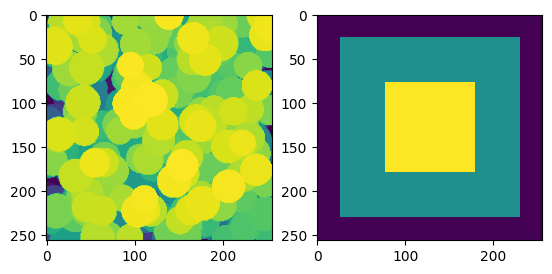

In [2]:
IMG_SHAPE = (256, 256)

shapes = random_shapely_circles(
    image_shape=IMG_SHAPE, 
    num_circles=500,
    min_radius=15,
    max_radius=20,
    seed=42,
    )

labeled_polygons = [(polygon, idx + 1) for idx, polygon in enumerate(shapes)]
labeled_array = rasterize(
    [(poly, label) for poly, label in labeled_polygons], 
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

broad_annotations = create_broad_annotation_polygons(image_shape=IMG_SHAPE)
labeled_broad_annotations = [(polygon, idx + 1) for idx, polygon in enumerate(broad_annotations)]
labeled_broad_annotations = rasterize(
    [(poly, label) for poly, label in labeled_broad_annotations], 
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(labeled_array)
ax[1].imshow(labeled_broad_annotations)

shapes = geopandas.GeoDataFrame(geometry=shapes)
broad_df = geopandas.GeoDataFrame(
    {
        "geometry": broad_annotations,
        "broad_annotation_id": ["edge", "cortex", "medulla"],
    }
)
broad_df = broad_df.set_index("broad_annotation_id")
shapes

In [3]:
shapes["spatial_axis"] = spatial_axis(
    shapes,
    broad_df,
    ["edge", "cortex", "medulla"],
    k_neighbours=5
)

shapes

,geometry,spatial_axis
0,"POLYGON ((114.542 243.383, 114.452 241.554, 11...",-1.130746
1,"POLYGON ((169.037 39.941, 168.961 38.394, 168....",-0.212941
2,"POLYGON ((32.875 221.741, 32.788 219.976, 32.5...",-1.296159
3,"POLYGON ((201.116 5.27, 201.021 3.324, 200.735...",-1.120639
4,"POLYGON ((229.014 54.359, 228.938 52.799, 228....",-0.238172
...,...,...
495,"POLYGON ((112.291 101.42, 112.203 99.609, 111....",0.931618
496,"POLYGON ((115.659 114.866, 115.581 113.279, 11...",0.899102
497,"POLYGON ((110.918 58.181, 110.844 56.675, 110....",0.058671
498,"POLYGON ((172.58 171.062, 172.493 169.289, 172...",0.910428


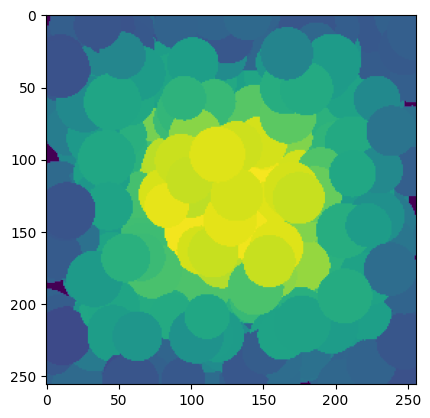

In [4]:
relative_array = spatial_axis_to_labelmap(
    shapes,
    IMG_SHAPE,
    background_value=-2
)

fig, ax = plt.subplots()
ax.imshow(relative_array)